In [1]:
import numpy as np
from numba import njit, prange
from matplotlib import ticker
from matplotlib import pyplot as plt
from itertools import product
import PIL


In [2]:
def allsequences_nobreak(n:int, elems:list=[1,-1]):
    lst = [seq for seq in product(elems, repeat=n) if seq[0]==elems[0] and not np.all(np.equal(seq[1:],np.zeros(n-1)))]
    return np.asarray(lst)

def allsequences_break(n:int, elems:list=[1,-1]):
    lst = []
    for seq in product(elems, repeat=n):
        if np.all(np.equal(seq[1:],np.zeros(n-1))):
            continue
        if seq[0]==elems[0]: 
            lst.append(seq)
        else:
            break
    return np.asarray(lst)

In [5]:
allsequences_break(3,[1,0,-1])

array([[ 1,  1,  1],
       [ 1,  1,  0],
       [ 1,  1, -1],
       [ 1,  0,  1],
       [ 1,  0, -1],
       [ 1, -1,  1],
       [ 1, -1,  0],
       [ 1, -1, -1]])

In [8]:
import time

LEVEL = 20
start = time.perf_counter()

seqs_nobreak = allsequences_nobreak(LEVEL)
generated_nobreak = time.perf_counter()

seqs_break = allsequences_break(LEVEL)
generated_break = time.perf_counter()


# Summarize execution time:
setup_time = round(generated_nobreak-start,3)
analysis_time = round(generated_break - generated_nobreak, 3)
total_time = round(generated_break - start, 3)

print(f"""
LEVEL {LEVEL}

Spent {setup_time} seconds generating all sequences with list comprehension.
Spent {analysis_time} seconds generating all sequences with for loop.
Spent {total_time} seconds in total.
""")


LEVEL 20

Spent 3.153 seconds generating all sequences with list comprehension.
Spent 3.308 seconds generating all sequences with for loop.
Spent 6.461 seconds in total.



In [9]:
%%timeit
allsequences_nobreak(LEVEL)


3.16 s ± 63.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
allsequences_break(LEVEL)

3.05 s ± 47.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
seqs = allsequences_break(3)
print(f"{seqs=}")
test = np.polynomial.polynomial.polyval(0.5+1j,seqs[1], False)
print(f"{test=}")
print(1+1*(0.5+1j)-1*(0.5+1j)**2)

seqs=array([[ 1,  1,  1],
       [ 1,  1, -1],
       [ 1, -1,  1],
       [ 1, -1, -1]])
test=(2.25+0j)
(2.25+0j)


In [11]:
LEVEL = 10
seqs = allsequences_break(LEVEL)

@njit
def polyval(x,c:list):
    r"""Evaluate a polynomial at points x.
    If `c` is of length `n + 1`, this function returns the value
    .. math:: p(x) = c_0 + c_1 * x + ... + c_n * x^n"""
    c0 = c[-1] + x*0
    for i in prange(2, len(c) + 1):
        c0 = c[-i] + c0*x
    return c0

from numba.typed import List

@njit#jit(nopython=True)
def ps(pt:np.complex128)->np.ndarray:
    """evaluate at pt the finite power series with coefficients from seqs.
    It returns an array of values"""
    vals=[]
    for i in prange(len(seqs)):
        vals.append(polyval(pt,seqs[i]))
    return np.asarray(vals)
#     return np.asarray([np.polynomial.polynomial.polyval(pt,seqs[i], False) for i in prange(len(seqs))])

@njit#jit(nopython=True)
def green(pt_list:np.ndarray)->np.float128:
    r"""compute the minimum of the absolute vales from pt_list. 
    Take the log and normalize by LEVEL.
    .. math:: \frac{1}{n} \log(\min (\left\vert \sum_{j=0}^{j=n-1}\epsilon_jx^j \right\vert))
    where 
    ..math:: \epsilon_j\in\{-1,1\}
    or 
    ..math:: \epsilon_j\in\{-1,0,1\}"""
    vals = np.log(np.min(np.abs(pt_list)))/LEVEL
    return vals

@njit#@jit(nopython=True)
def param(c, x_dim = 500, y_dim = 500):
    cntr = np.zeros_like(c, dtype=np.float64)
    for y in prange(y_dim):
        for x in prange(x_dim):
            if c[y][x]==0:
                cntr[y][x]=1e10
                continue
            if np.abs(c[y][x])>=2**(-0.25):
                cntr[y][x]=0
                continue
            pt = 1/c[y][x]
            cntr[y][x] = green(ps(pt))
    return cntr

In [12]:
x_dim = 800
y_dim = 800


x_min = 0.001
x_max = 0.710
y_min = 0.001j
y_max = 0.710j


# This is the Complex plane
cplx_plane = np.zeros((y_dim,x_dim),dtype=np.complex128)# Create a x_dim by y_dim array of numbers 0.0+0.0j.
for l in range(y_dim):
    cplx_plane[l] = np.linspace(x_min,x_max,x_dim) - np.linspace(y_min,y_max,y_dim)[l]
    #change the zeroes into the correct complex numbers based on the dimensions.

In [16]:
%%timeit

# This computes the points in the set
barnsley = param(cplx_plane,x_dim,y_dim) 

7.44 s ± 719 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


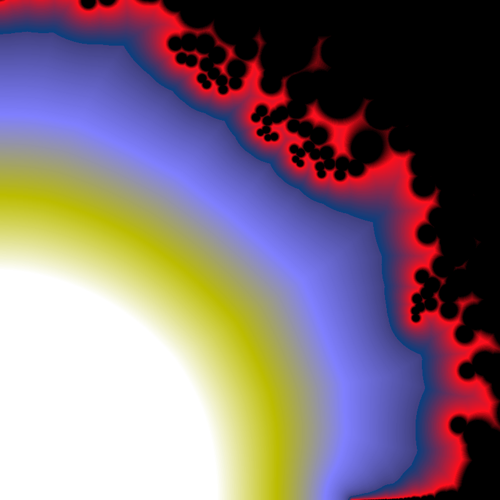

In [19]:
# turbo, plasma, viridis, cividis, gist_stern, jet, twilight, twilight_shifted, binary

# This draws the Image
colors = plt.cm.gist_stern(barnsley)*255
colors = np.array(colors, dtype=np.uint8)
new_image = PIL.Image.fromarray(colors)
new_image = new_image.transpose(PIL.Image.Transpose.FLIP_TOP_BOTTOM)
img=new_image.resize((500,500))
img.show()

In [164]:
LEVEL = 6
seqs = allsequences_break(LEVEL,[1,0,-1])

def compute(x,y):
    return green(ps(1/(x+y*1j)))

G = np.vectorize(compute)

x_dim, y_dim = (600,600)

x_min, x_max = (0.001, 0.710)
y_min, y_max = (0.001, 0.710)

x = np.linspace(x_min,x_max,x_dim)
y = np.linspace(y_min,y_max,y_dim)

xs, ys =np.meshgrid(x,y)

In [81]:
%%timeit
zs = G(xs,ys)

16 s ± 858 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [165]:
zs = G(xs,ys)

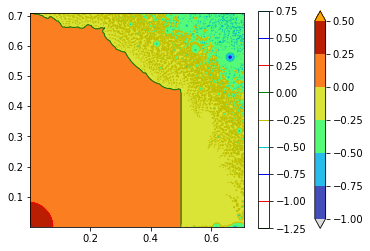

In [166]:
levels=np.linspace(-1.25,1,5)
cmap = plt.colormaps["turbo"].with_extremes(under="gainsboro", over="orange")
plt.contourf(xs, ys, zs,cmap=cmap, extend="both")
plt.colorbar()
plt.contour(x, y, zs, colors=('g','r','b','c','y',),linewidths=(1,))
plt.colorbar()
plt.axis('scaled')
plt.show()


In [77]:
def grad(x,y,wh=True,delta=0.01):
    return G(x+delta,y)-G(xs,ys) if wh else G(x,y+delta)-G(xs,ys)
dG = np.vectorize(grad)
U = dG(xs,ys)
V = dG(xs,ys,False)

KeyboardInterrupt: 

In [ ]:
plt.streamplo(x,y,U,V)

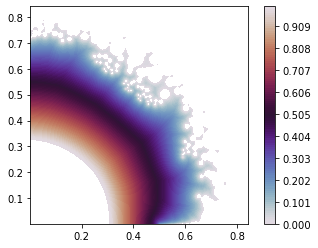

In [45]:
h = plt.contourf(x, y, zs, levels=np.linspace(0,1,100), cmap=plt.cm.twilight) #locator=ticker.LogLocator(),
plt.axis('scaled')
plt.colorbar()
plt.show()

In [137]:
2**(-0.25)

0.8408964152537145